In [1]:
%cd ..

/home/dawood/Workspace/compoundGAN


In [2]:
import os
import sys

import torch
import joypy
import dgl
import random
import networkx as nx
import numpy as np

from tqdm.notebook import tqdm 
from collections import defaultdict

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import RDConfig
from rdkit.Chem import QED
from rdkit.Chem import AllChem

sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

import selfies
from selfies import encoder as selfies_encoder
from selfies import decoder as selfies_decoder
from data.selfies import SELFIES, SELFIE_VOCAB, SELFIES_STEREO

from models.network import CVAEF

from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import umap
from cvae import cvae

%matplotlib inline

import seaborn as sns
from matplotlib import colors
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('fivethirtyeight')


import pandas as pd

DEVICE = torch.device('cuda:0')

random.seed(42)

In [3]:
def make_views(fig, ax,angles,elevation=None, width=4, height = 3,
                prefix='tmprot_',**kwargs):
    """
    Makes jpeg pictures of the given 3d ax, with different angles.
    Args:
        ax (3D axis): te ax
        angles (list): the list of angles (in degree) under which to
                       take the picture.
        width,height (float): size, in inches, of the output images.
        prefix (str): prefix for the files created. 
     
    Returns: the list of files created (for later removal)
    """
     
    files = []
    # fig.set_size_inches(width,height)

    for i,angle in enumerate(angles):
        for _ax in ax:
            _ax.view_init(elev = elevation, azim=angle)
        fname = '%s%03d.png'%(prefix,i)
        fig.savefig(fname, dpi=120)
        files.append(fname)
     
    return files
 
 
 
##### TO TRANSFORM THE SERIES OF PICTURE INTO AN ANIMATION
 
def make_movie(files,output, fps=10,bitrate=1800,**kwargs):
    """
    Uses mencoder, produces a .mp4/.ogv/... movie from a list of
    picture files.
    """
     
    output_name, output_ext = os.path.splitext(output)
    command = { '.mp4' : 'mencoder "mf://%s" -mf fps=%d -o %s.mp4 -ovc lavc\
                         -lavcopts vcodec=msmpeg4v2:vbitrate=%d'
                         %(",".join(files),fps,output_name,bitrate)}
                          
    command['.ogv'] = command['.mp4'] + '; ffmpeg -i %s.mp4 -r %d %s'%(output_name,fps,output)
     
    output_ext = os.path.splitext(output)[1]
    os.system(command[output_ext])
    
    
def make_gif(files,output,delay=100, repeat=True,**kwargs):
    """
    Uses imageMagick to produce an animated .gif from a list of
    picture files.
    """
     
    loop = -1 if repeat else 0
    os.system('ffmpeg -t 4 -i tmprot_%%03d.png %s'%(output))
 
 
def make_strip(files,output,**kwargs):
    """
    Uses imageMagick to produce a .jpeg strip from a list of
    picture files.
    """
     
    os.system('montage -tile 1x -geometry +0+0 %s %s'%(" ".join(files),output))
     
     
     
##### MAIN FUNCTION
 
def rotanimate(fig, ax, angles, output, **kwargs):
    """
    Produces an animation (.mp4,.ogv,.gif,.jpeg,.png) from a 3D plot on
    a 3D ax
     
    Args:
        ax (3D axis): the ax containing the plot of interest
        angles (list): the list of angles (in degree) under which to
                       show the plot.
        output : name of the output file. The extension determines the
                 kind of animation used.
        **kwargs:
            - width : in inches
            - heigth: in inches
            - framerate : frames per second
            - delay : delay between frames in milliseconds
            - repeat : True or False (.gif only)
    """
         
    output_ext = os.path.splitext(output)[1]
 
    files = make_views(fig, ax,angles, **kwargs)
     
    D = { '.mp4' : make_movie,
          '.ogv' : make_movie,
          '.gif': make_gif ,
          '.jpeg': make_strip,
          '.png':make_strip}
           
    D[output_ext](files,output,**kwargs)
     
#     for f in files:
#         os.remove(f)

In [4]:
state_dict = torch.load('/home/dawood/Experiments/compound-gan-8e768223b3e4488391898bdeecdb7b5a/model_200.weights', map_location='cpu')
seq_len = 300

In [5]:
D = 256
L = D
C = 3
DIM_TOKEN = 139
model = CVAEF([DIM_TOKEN, 3], D,
              [L, L, L, L], C, 0.9, True, use_adjoint=False, num_decoder_layers=4)
model.load_state_dict(state_dict['parameters'])
model = model.eval().to(DEVICE)

In [6]:
def pred2smiles(x):
    seq = []
    iterator = zip(x[:, :DIM_TOKEN].argmax(-1).long().tolist(), x[:, DIM_TOKEN:].argmax(-1).long().tolist())
    for n, (i, j) in enumerate(iterator):
        t = SELFIE_VOCAB[i]
        s = SELFIES_STEREO[j]

        if i != 0 and i != 1:
            t = '[' + s + t[1:]

        seq.append(t)

        if i == 1:
            break
        
    selfie = ''.join(seq)
    smiles = selfies.decoder(selfie.replace('[START]', '').replace('[END]', ''))
    
    try:
        mol = Chem.MolFromSmiles(smiles, sanitize=False)
        Chem.SanitizeMol(mol, catchErrors=False)
        smiles = Chem.MolToSmiles(mol)
    except Exception as e:
        print('MOL ERROR : ', e)
        return '', None, False

    try:
        AllChem.AssignAtomChiralTagsFromStructure(mol,confId=-1,replaceExistingTags=True)
        is_3d_valid = AllChem.EmbedMolecule(mol, useExpTorsionAnglePrefs=True, useBasicKnowledge=True, useRandomCoords=True)        
        AllChem.MMFFOptimizeMolecule(mol)
        is_3d_valid = True
    except Exception as e:
        print('MOL ERROR : 3D Invalid ', e)
        is_3d_valid = False
        
    return smiles, mol, is_3d_valid

In [7]:
def generate_latentspace_info(num_mols = 1000, batch_size = 32, max_seq_len = 300):
    
    data = []
    
    for i in tqdm(range(num_mols//batch_size)):
        
        # draw Z from Gaussian
        z = torch.zeros((batch_size, D  - C))
        z.normal_(0, 1)
        
        if C > 0:
            condition = torch.zeros((batch_size, C))
            condition.uniform_(0, 1)
            for j in range(batch_size):
                condition[j, 0] = ((condition[j, 0] - 0.5) * 12).int().float()
                condition[j, 1] = ((condition[j, 1] * 15).int().float())
                condition[j, 2] = ((condition[j, 2] * 10).int().float())
            #print(condition)
            z = torch.cat([z, condition], dim=1)
        
        z = z.to(DEVICE)
        
        # W = CNF^-1(Z)
        w = model.cnf(z, None, True)[0]
        
        # Predict
        pred = model.decoder.generate(z, max_seq_len)

        for b in range(batch_size):
            smiles, mol, is_3d_valid = pred2smiles(pred[:, b])
            logP_data = None
            tpsa_data = None
            sas_data  = None
            
            if mol is not None:
                try:
                    logP_data = (condition[b, 0].int().item(), Chem.Descriptors.MolLogP(mol))
                    tpsa_data = (condition[b, 1].item() * 10, Chem.Descriptors.TPSA(mol, includeSandP=True))
                    sas_data  = (condition[b, 2].item(), sascorer.calculateScore(mol))                
                except:
                    pass
                
            data.append({
                'smiles': smiles,
                'mol': mol,
                'is_3d_valid': is_3d_valid,
                'z': z[b].data.cpu().numpy(),
                'w': w[b].data.cpu().numpy(),
                'logP': logP_data,
                'tpsa': tpsa_data,
                'sas' : sas_data
            })
        
    return data

In [36]:
data = generate_latentspace_info(12800, 128, 300)

MOL ERROR :  Sanitization error: Explicit valence for atom # 21 O, 4, is greater than permitted
MOL ERROR : 3D Invalid  Invariant Violation
	Cannot be a chiral center
	Violation occurred on line 684 in file Code/GraphMol/DistGeomHelpers/Embedder.cpp
	Failed Expression: nbrs.size() >= 3
	RDKIT: 2019.03.4
	BOOST: 1_67

MOL ERROR :  Sanitization error: Explicit valence for atom # 4 N, 4, is greater than permitted
MOL ERROR : 3D Invalid  Invariant Violation
	Cannot be a chiral center
	Violation occurred on line 684 in file Code/GraphMol/DistGeomHelpers/Embedder.cpp
	Failed Expression: nbrs.size() >= 3
	RDKIT: 2019.03.4
	BOOST: 1_67

MOL ERROR : 3D Invalid  Invariant Violation
	Cannot be a chiral center
	Violation occurred on line 684 in file Code/GraphMol/DistGeomHelpers/Embedder.cpp
	Failed Expression: nbrs.size() >= 3
	RDKIT: 2019.03.4
	BOOST: 1_67

MOL ERROR :  Sanitization error: Explicit valence for atom # 9 N, 4, is greater than permitted
MOL ERROR :  Sanitization error: Explicit val

In [37]:
filtered_data = list(filter(lambda x : x['mol'] is not None, data))
z_data = np.array([d['z'] for d in filtered_data])
w_data = np.array([d['w'] for d in filtered_data])

w_tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=5000)
w_tsne_results = w_tsne.fit_transform(w_data)

z_tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=5000)
z_tsne_results = z_tsne.fit_transform(z_data)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 11199 samples in 0.100s...
[t-SNE] Computed neighbors for 11199 samples in 58.464s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11199
[t-SNE] Computed conditional probabilities for sample 2000 / 11199
[t-SNE] Computed conditional probabilities for sample 3000 / 11199
[t-SNE] Computed conditional probabilities for sample 4000 / 11199
[t-SNE] Computed conditional probabilities for sample 5000 / 11199
[t-SNE] Computed conditional probabilities for sample 6000 / 11199
[t-SNE] Computed conditional probabilities for sample 7000 / 11199
[t-SNE] Computed conditional probabilities for sample 8000 / 11199
[t-SNE] Computed conditional probabilities for sample 9000 / 11199
[t-SNE] Computed conditional probabilities for sample 10000 / 11199
[t-SNE] Computed conditional probabilities for sample 11000 / 11199
[t-SNE] Computed conditional probabilities for sample 11199 / 11199
[t-SNE] Mean sigma: 4.752672
[t-SNE] KL divergen

In [38]:
def latent_plot(fig, pos, tsne_result, label, title='', cmap='plasma'):
    ax = plt.subplot(*pos)
    ax.set_title(title)
    p = ax.scatter(
        tsne_result[:, 0],
        tsne_result[:, 1],
        c = label,
        cmap=cmap,
        label = label,
        s = 20
    )
    fig.colorbar(p, ax=ax)
    plt.axis('off')
    return ax

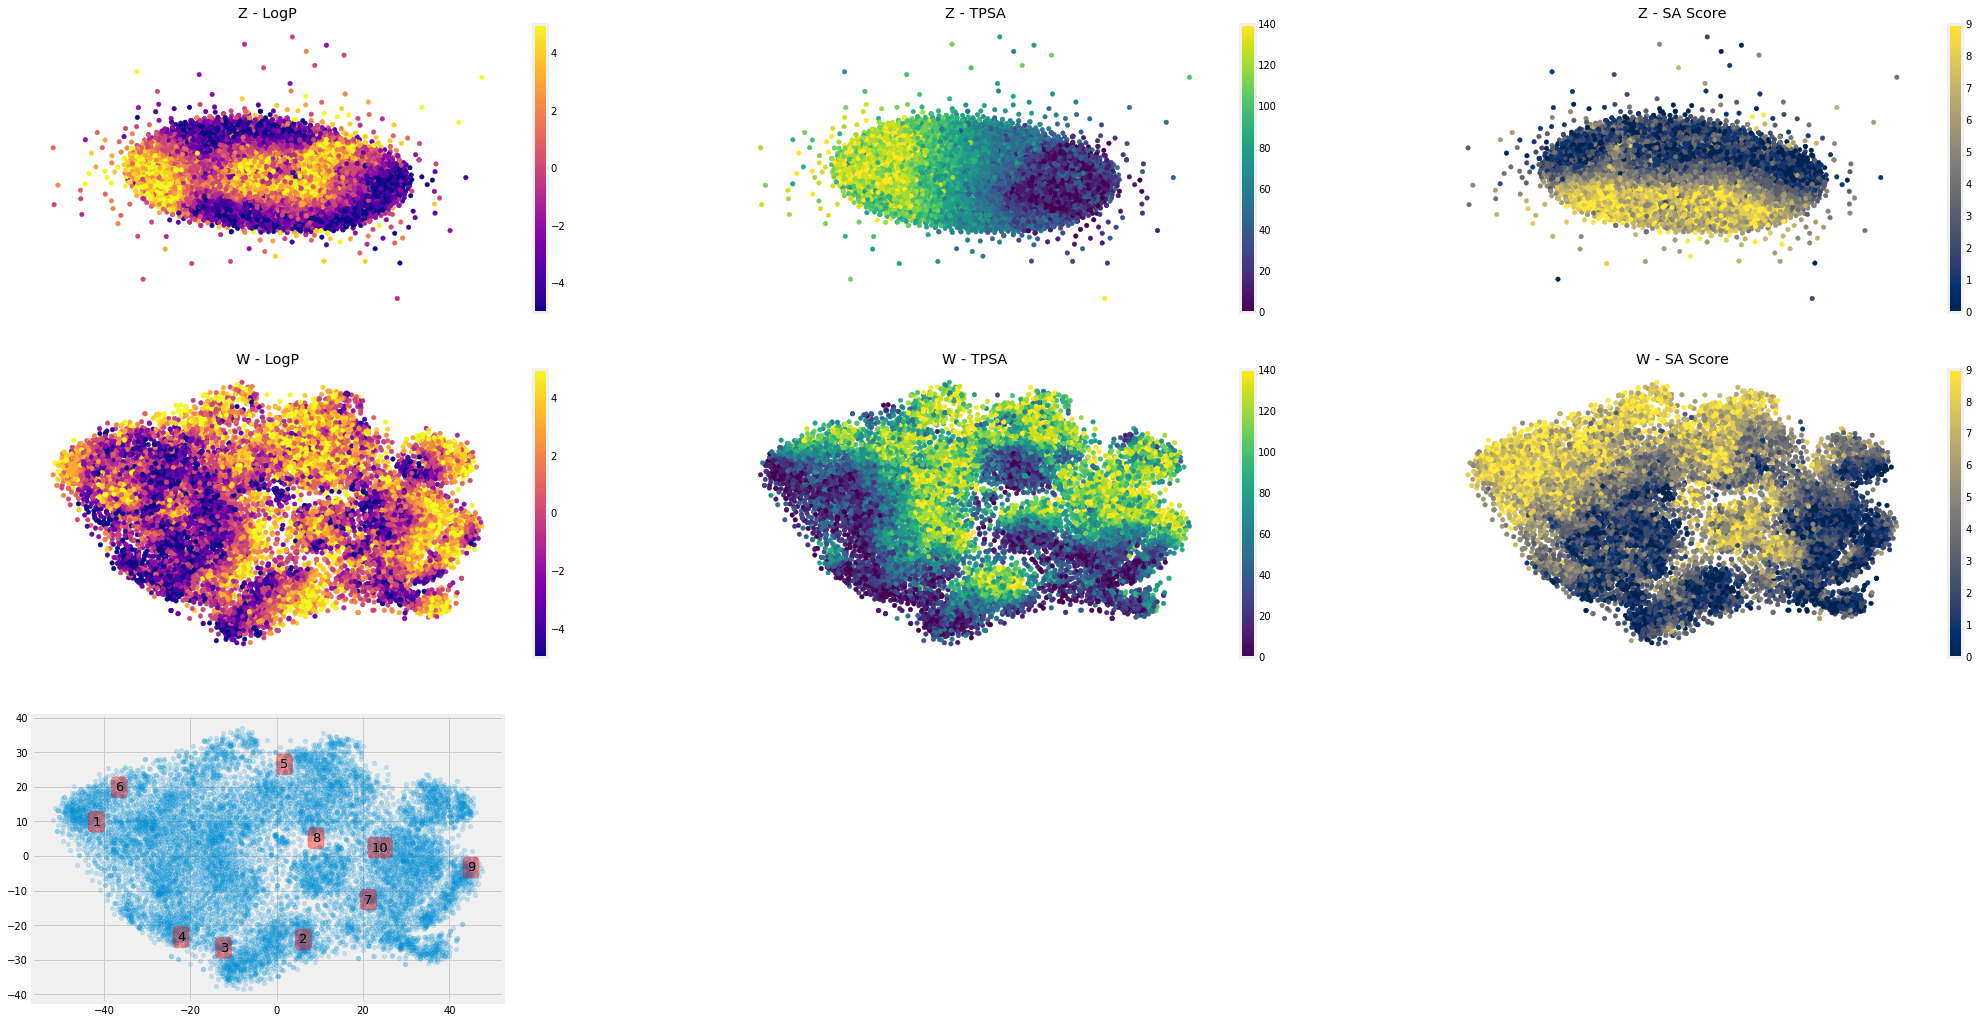

In [58]:
fig = plt.figure(figsize = (32, 18))
ax1 = latent_plot(fig, (3,3,1), z_tsne_results, [d['logP'][0] for d in filtered_data], 'Z - LogP', 'plasma')
ax2 = latent_plot(fig, (3,3,2), z_tsne_results, [d['tpsa'][0] for d in filtered_data], 'Z - TPSA', 'viridis')
ax3 = latent_plot(fig, (3,3,3), z_tsne_results, [d['sas'][0] for d in filtered_data], 'Z - SA Score', 'cividis')

ax4 = latent_plot(fig, (3,3,4), w_tsne_results, [d['logP'][0] for d in filtered_data], 'W - LogP', 'plasma')
ax5 = latent_plot(fig, (3,3,5), w_tsne_results, [d['tpsa'][0] for d in filtered_data], 'W - TPSA', 'viridis')
ax6 = latent_plot(fig, (3,3,6), w_tsne_results, [d['sas'][0] for d in filtered_data], 'W - SA Score', 'cividis')

ax = plt.subplot(3,3,7)
p = ax.scatter(
    w_tsne_results[:, 0],
    w_tsne_results[:, 1],
    s = 20,
    alpha=0.2
)
cb = fig.colorbar(p, ax=ax)
cb.remove()

mol_indices = random.sample(range(len(w_tsne_results)), 10)
for i,j in enumerate(mol_indices):
    (x, y) = w_tsne_results[j]
    ax.annotate('%d'%(i+1), xy=(x, y), xytext=(x, y), size=13, ha='right', va="center",
             bbox=dict(boxstyle="round", alpha=0.4, color="red"))
    
plt.show()

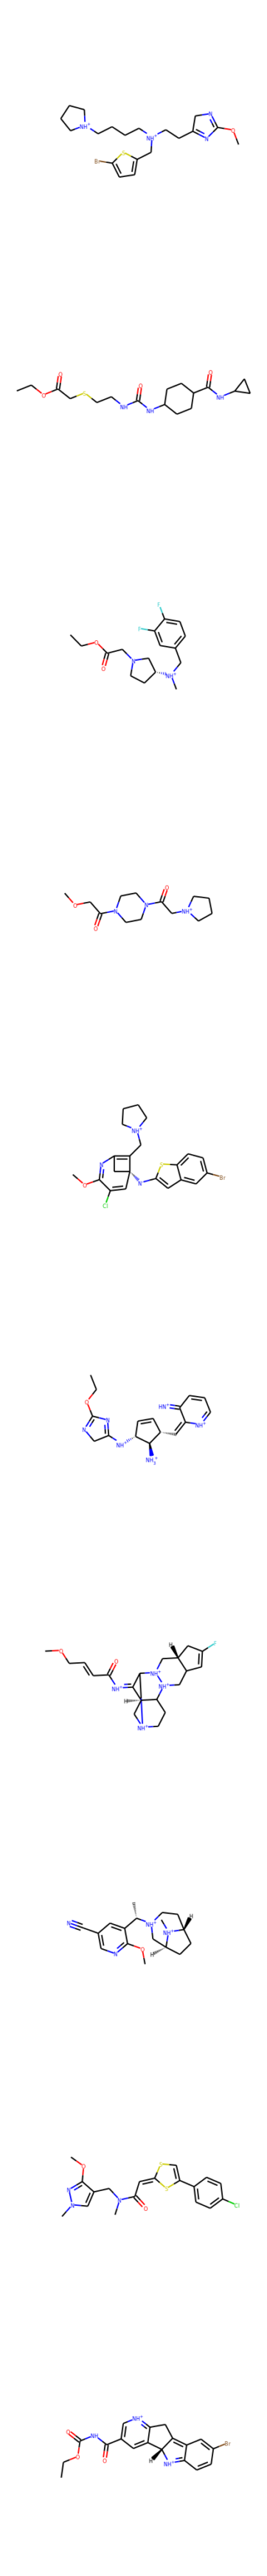

In [83]:
mols = []
smiles = []
for i in mol_indices:
    #print(filtered_data[i])
    smiles.append(filtered_data[i]['smiles'])
    mols.append(Chem.MolFromSmiles(filtered_data[i]['smiles']))
    #mol = Chem.MolFromSmiles(smiles)
    
img = Draw.MolsToGridImage(mols, molsPerRow=1, subImgSize=(400, 400))
plt.figure(figsize=(64, 64))
plt.imshow(img, interpolation='bilinear')
plt.axis('off')
plt.show()

In [84]:
smiles

['COC1=N[CH]C([CH]C[NH+](C[CH][CH]C[NH+]2CCCC2)Cc2ccc(Br)s2)=N1',
 'CCOC(=O)CSCCNC(=O)NC1CCC(C(=O)NC2CC2)CC1',
 'CCOC(=O)CN1CC[C@@H]([NH+](C)Cc2ccc(F)c(F)c2)C1',
 'COCC(=O)N1CCN(C(=O)C[NH+]2CCCC2)CC1',
 'COC1=NC2=C(C[NH+]3CCCC3)[C@@]([N-]c3cc4cc(Br)ccc4s3)(C=C1Cl)C2',
 'CCOC1=N[CH]C([NH+][C@@H]2C=C[C@H](C=C3[NH+]=CC=CC3=[NH+])[C@H]2[NH3+])=N1',
 'COCC=CC(=O)[NH+]=C1C2[NH+]3CCC([C@H]1C3)[NH+]1C[C]3C=C(F)C[C@H]3C[NH+]21',
 'COc1ncc(C#N)cc1[C@H](C)[NH+]1CC[C@@H]2CC[C@@H](C1)[NH+]2C',
 'COc1nn(C)cc1CN(C)C(=O)/C=C1/SC=C(c2ccc(Cl)cc2)S1',
 'CCOC(=O)NC(=O)c1c[nH+]c2c(c1)[C@H]1[NH+]=c3ccc(Br)cc3=C1[CH]2']

In [56]:
filtered_data = list(filter(lambda x : x['mol'] is not None, data))
z_data = np.array([d['z'] for d in filtered_data])
w_data = np.array([d['w'] for d in filtered_data])

w_tsne = TSNE(n_components=3, verbose=1, perplexity=100, n_iter=5000)
w_tsne_results = w_tsne.fit_transform(w_data)

z_tsne = TSNE(n_components=3, verbose=1, perplexity=100, n_iter=5000)
z_tsne_results = z_tsne.fit_transform(z_data)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 11214 samples in 0.090s...
[t-SNE] Computed neighbors for 11214 samples in 60.119s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11214
[t-SNE] Computed conditional probabilities for sample 2000 / 11214
[t-SNE] Computed conditional probabilities for sample 3000 / 11214
[t-SNE] Computed conditional probabilities for sample 4000 / 11214
[t-SNE] Computed conditional probabilities for sample 5000 / 11214
[t-SNE] Computed conditional probabilities for sample 6000 / 11214
[t-SNE] Computed conditional probabilities for sample 7000 / 11214
[t-SNE] Computed conditional probabilities for sample 8000 / 11214
[t-SNE] Computed conditional probabilities for sample 9000 / 11214
[t-SNE] Computed conditional probabilities for sample 10000 / 11214
[t-SNE] Computed conditional probabilities for sample 11000 / 11214
[t-SNE] Computed conditional probabilities for sample 11214 / 11214
[t-SNE] Mean sigma: 4.779849
[t-SNE] KL divergen

In [64]:
def latent_plot(fig, pos, tsne_result, label, title='', cmap='plasma'):
    ax = plt.subplot(*pos, projection='3d')
    ax.set_title(title)
    p = ax.scatter(
        tsne_result[:, 0],
        tsne_result[:, 1],
        tsne_result[:, 2],
        c = label,
        cmap=cmap,
        label = label,
        s = 20
    )
    fig.colorbar(p, ax=ax)
    plt.axis('off')
    return ax

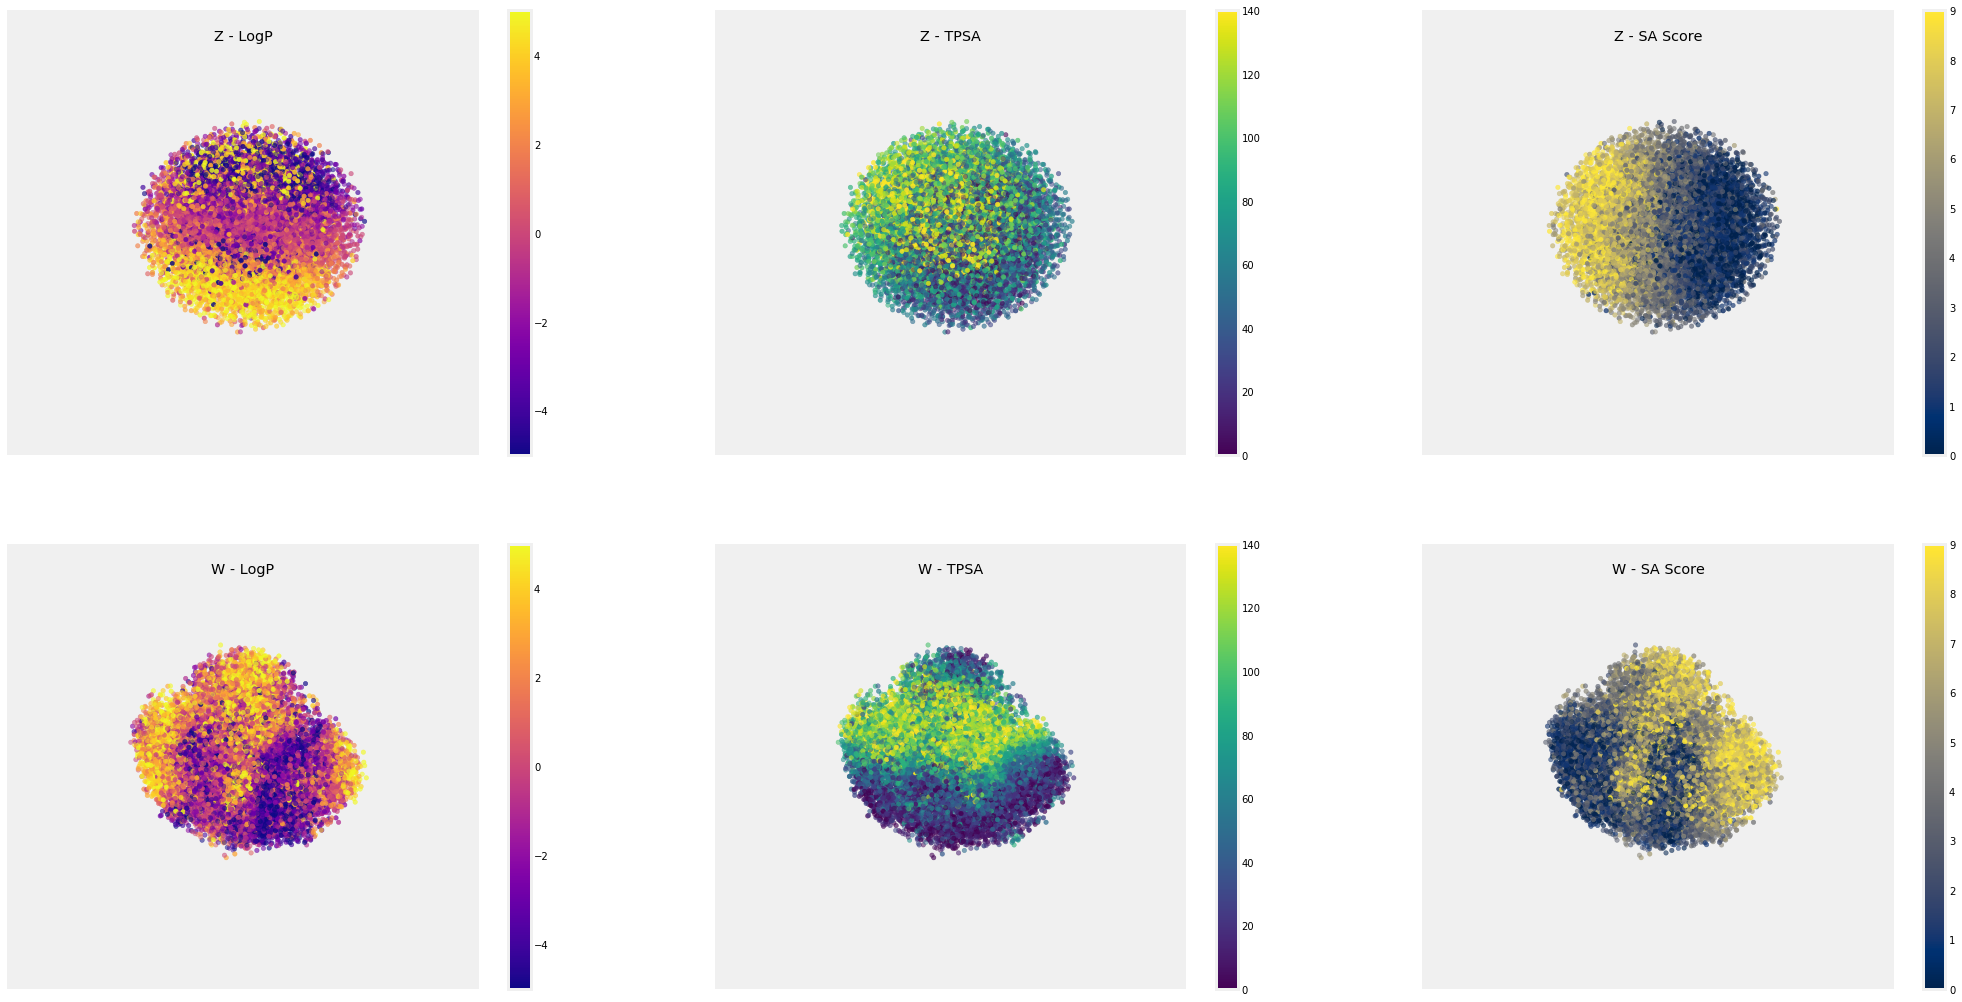

In [65]:
fig = plt.figure(figsize = (32, 18))
ax1 = latent_plot(fig, (2,3,1), z_tsne_results, [d['logP'][0] for d in filtered_data], 'Z - LogP', 'plasma')
ax2 = latent_plot(fig, (2,3,2), z_tsne_results, [d['tpsa'][0] for d in filtered_data], 'Z - TPSA', 'viridis')
ax3 = latent_plot(fig, (2,3,3), z_tsne_results, [d['sas'][0] for d in filtered_data], 'Z - SA Score', 'cividis')

ax4 = latent_plot(fig, (2,3,4), w_tsne_results, [d['logP'][0] for d in filtered_data], 'W - LogP', 'plasma')
ax5 = latent_plot(fig, (2,3,5), w_tsne_results, [d['tpsa'][0] for d in filtered_data], 'W - TPSA', 'viridis')
ax6 = latent_plot(fig, (2,3,6), w_tsne_results, [d['sas'][0] for d in filtered_data], 'W - SA Score', 'cividis')

# plt.savefig('Z2W_TSNE_all_properties.png', dpi=200)
# plt.show()

ax = [ax1, ax2, ax3, ax4, ax5, ax6]
angles = np.linspace(0,360,61)[:-1] # A list of 20 angles between 0 and 360
rotanimate(fig, ax, angles,'z_logp_predicted.gif',delay=20, height=18, width=32) 

## How does the latent space change

In [4]:
state_dict = torch.load('/home/dawood/Experiments/compound-gan-615b4223c0c34271aee9ae495e6199d4/model_364.weights', map_location='cpu')
seq_len = 300

In [5]:
D = 256
L = D
C = 2
DIM_TOKEN = 139
model = CVAEF([DIM_TOKEN, 3], D,
              [L, L, L, L], C, 0.9, True, use_adjoint=False, num_decoder_layers=4)
model.load_state_dict(state_dict['parameters'])
model = model.eval().to(DEVICE)

In [6]:
num_mols   = 1024
batch_size = 512

Z_arr = []
W_arr = defaultdict(list)

for i in tqdm(range(num_mols//batch_size)):    
    Z = torch.zeros((batch_size, D - C))
    Z.normal_(0, 1)

    Z_arr.append(Z.data)
    
    for logp_target in tqdm(range(2, 6)):
        for tpsa_target in tqdm(range(2, 7)):
            # print(logp_target, tpsa_target)
            
            condition = torch.zeros((batch_size, C))
            condition[:, 0] = float(logp_target)
            condition[:, 1] = float(tpsa_target)

            Z_c = torch.cat([Z, condition], 1)
            Z_c = Z_c.to(DEVICE)

            W = model.cnf(Z_c, None, True)[0]

            W_arr[(logp_target, tpsa_target)].append(W.data.cpu())

In [8]:
Z = torch.cat(Z_arr, 0)
W = {}
for k in W_arr:
    W[k] = torch.cat(W_arr[k], 0)

In [9]:
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=5000)

Z_tsne = tsne.fit_transform(Z.numpy())
W_tsne = {}
for k in tqdm(W):
    tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=5000)
    W_tsne[k] = tsne.fit_transform(W[k].numpy())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1024 samples in 0.006s...
[t-SNE] Computed neighbors for 1024 samples in 0.480s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1024
[t-SNE] Computed conditional probabilities for sample 1024 / 1024
[t-SNE] Mean sigma: 3.560200
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.718033
[t-SNE] KL divergence after 1550 iterations: 2.130953


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1024 samples in 0.006s...
[t-SNE] Computed neighbors for 1024 samples in 0.507s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1024
[t-SNE] Computed conditional probabilities for sample 1024 / 1024
[t-SNE] Mean sigma: 5.278791
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.614792
[t-SNE] KL divergence after 1700 iterations: 1.125659
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1024 samples in 0.004s...
[t-SNE] Computed neighbors for 1024 samples in 0.507s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1024
[t-SNE] Computed conditional probabilities for sample 1024 / 1024
[t-SNE] Mean sigma: 5.649526
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.281319
[t-SNE] KL divergence after 950 iterations: 1.134791
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1024 samples in 0.006s...
[t-SNE] Computed neighbors for 1024 samples in

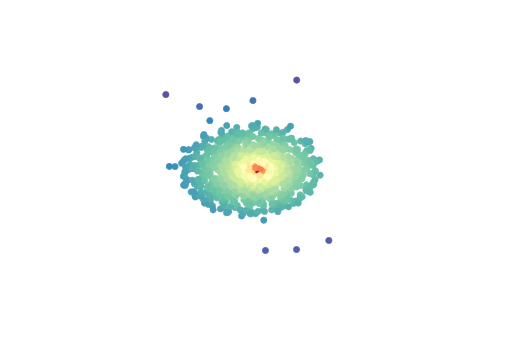

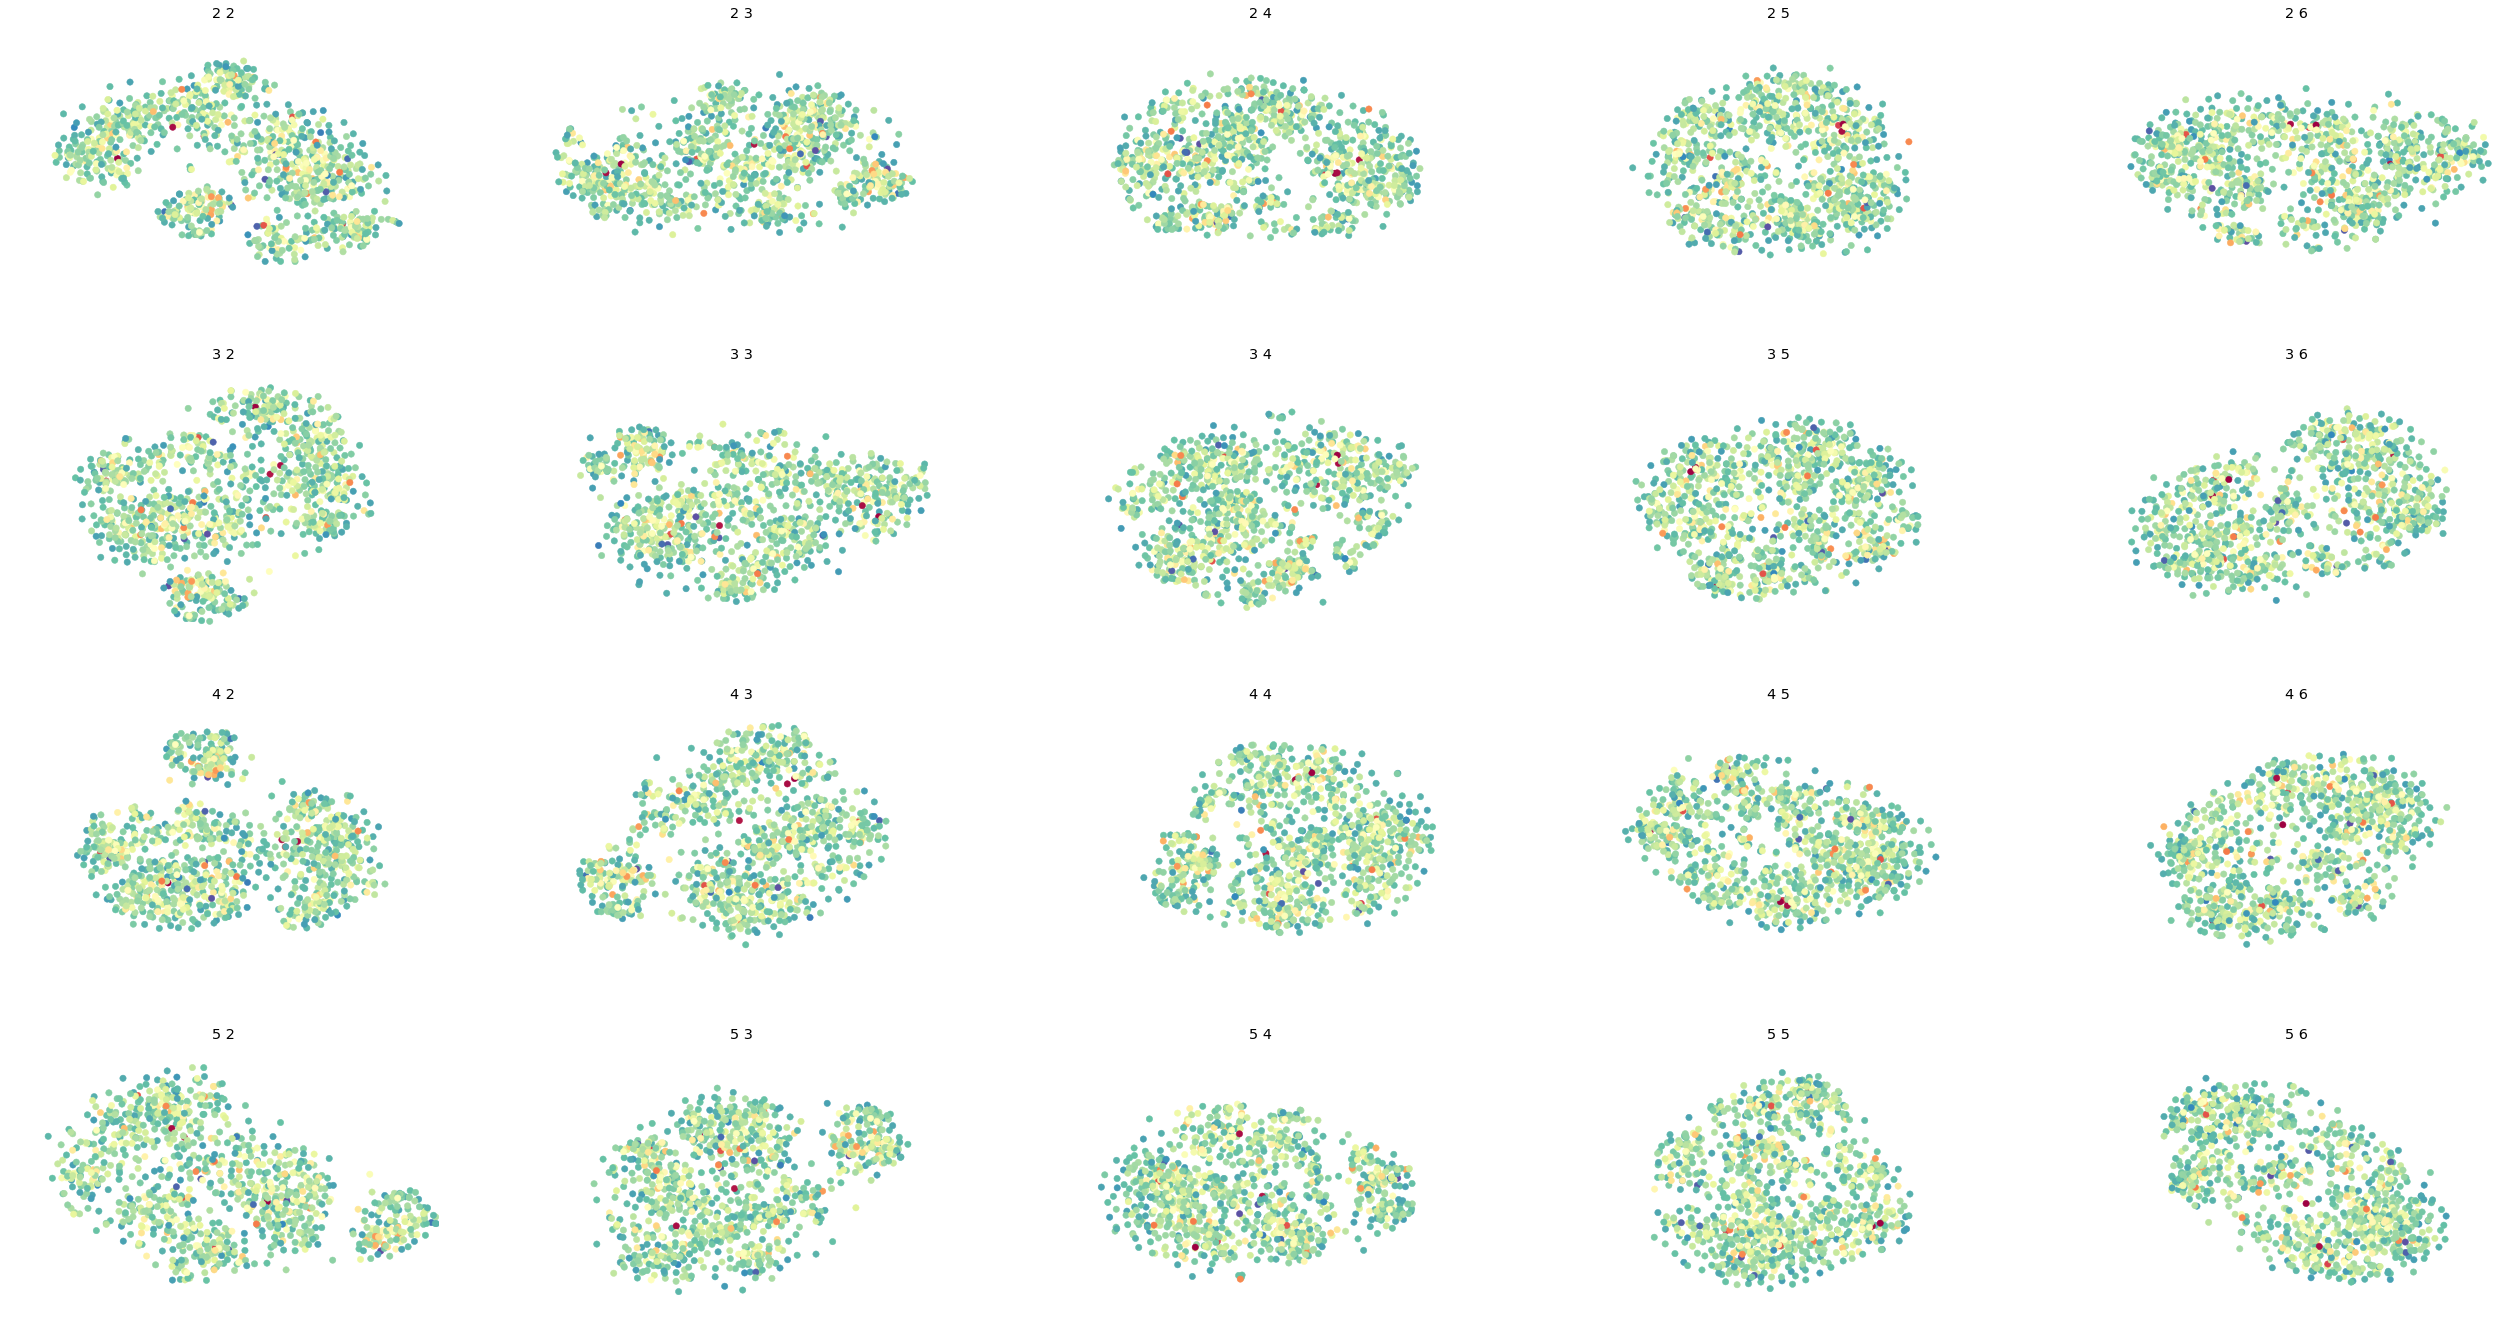

In [12]:
def latent_plot(fig, pos, tsne_result, title='', cmap='plasma'):
    ax = plt.subplot(*pos)
    ax.set_title(title)
    p = ax.scatter(
        tsne_result[:, 0],
        tsne_result[:, 1],
        cmap=cmap,
        s = 20
    )
    plt.axis('off')
    return ax

R = 10
S = 40
color = (Z_tsne[:, 0]**2 + Z_tsne[:, 1]**2) ** 0.5
norm=colors.LogNorm(vmin=color.min(), vmax=color.max())
cmap='Spectral'

plt.figure(figsize=(8, 6))
plt.scatter(
    Z_tsne[:, 0],
    Z_tsne[:, 1],
    c = color,
    cmap=cmap,
    norm=norm,
    s=S
)
plt.xlim(-R, R)
plt.ylim(-R, R)
plt.axis('off')

R = 14
fig = plt.figure()
i = 1
for logp_target in tqdm(range(2, 6)):
        for tpsa_target in tqdm(range(2, 7)):
            ax = plt.subplot(4, 5, i)
            ax.set_title('%d %d'%(logp_target, tpsa_target))
            ax.scatter(
                W_tsne[(logp_target, tpsa_target)][:, 0],
                W_tsne[(logp_target, tpsa_target)][:, 1],
                c = color,
                cmap=cmap,
                norm=norm,
                s=S
            )
            plt.xlim(-R, R)
            plt.ylim(-R, R)
            plt.axis('off')
            i += 1
fig.set_size_inches(8*5, 6*4)

plt.savefig('test.png', dpi=200)
plt.show()

In [13]:
from cvae import cvae

In [14]:
cv = cvae.CompressionVAE(X=Z.numpy(), )
cv.train()
Z_tsne = cv.embed(Z.numpy())

W_tsne = {}
for k in tqdm(W):
    cv = cvae.CompressionVAE(X=W[k].numpy())
    cv.train()
    W_tsne[k] = cv.embed(W[k].numpy())

Total amount of data:  921
Input feature dimension:  254
Calculating normalisation factors.
Normalisation factors calculated.
Total amount of data:  103
Creating model.
Model created.
Setting up loss.
Loss set up.
Setting up session.
Session set up.
Trying to restore saved checkpoints from /home/dawood/Workspace/compoundGAN/temp ... No checkpoint found.
No model found to restore. Initialising new model.
Starting queues.
Reader threads started.
step 0; epoch 0.00 - loss = 131.630, test_loss = 128.053, lr = 0.00100, (0.018 sec/step)
Storing checkpoint to /home/dawood/Workspace/compoundGAN/temp ... Done.
step 50; epoch 3.47 - loss = 125.554, test_loss = 126.189, lr = 0.00100, (0.001 sec/step)
step 100; epoch 6.95 - loss = 128.848, test_loss = 126.098, lr = 0.00100, (0.001 sec/step)
step 150; epoch 10.42 - loss = 126.426, test_loss = 126.109, lr = 0.00100, (0.000 sec/step)
step 200; epoch 13.90 - loss = 126.089, test_loss = 126.049, lr = 0.00100, (0.001 sec/step)
step 250; epoch 17.37 - lo

Total amount of data:  921
Input feature dimension:  256
Calculating normalisation factors.
Normalisation factors calculated.
Total amount of data:  103
Creating model.
Model created.
Setting up loss.
Loss set up.
Setting up session.
Session set up.
Trying to restore saved checkpoints from /home/dawood/Workspace/compoundGAN/temp ... No checkpoint found.
No model found to restore. Initialising new model.
Starting queues.
Reader threads started.
step 0; epoch 0.00 - loss = 129.106, test_loss = 133.416, lr = 0.00100, (0.021 sec/step)
Storing checkpoint to /home/dawood/Workspace/compoundGAN/temp ... Done.
step 50; epoch 3.47 - loss = 128.721, test_loss = 131.506, lr = 0.00100, (0.000 sec/step)
step 100; epoch 6.95 - loss = 125.089, test_loss = 131.300, lr = 0.00100, (0.001 sec/step)
step 150; epoch 10.42 - loss = 126.172, test_loss = 131.153, lr = 0.00100, (0.001 sec/step)
step 200; epoch 13.90 - loss = 124.619, test_loss = 125.623, lr = 0.00100, (0.001 sec/step)
step 250; epoch 17.37 - lo

(-0.1, 0.1, -0.1, 0.1)

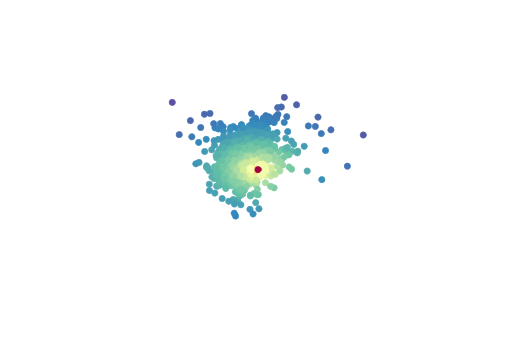

In [15]:
R = 0.1
S = 40
color = (Z_tsne[:, 0]**2 + Z_tsne[:, 1]**2) ** 0.5
norm=colors.LogNorm(vmin=color.min(), vmax=color.max())
cmap='Spectral'

plt.figure(figsize=(8, 6))
plt.scatter(
    Z_tsne[:, 0],
    Z_tsne[:, 1],
    c = color,
    cmap=cmap,
    norm=norm,
    s=S
)
plt.xlim(-R, R)
plt.ylim(-R, R)
plt.axis('off')

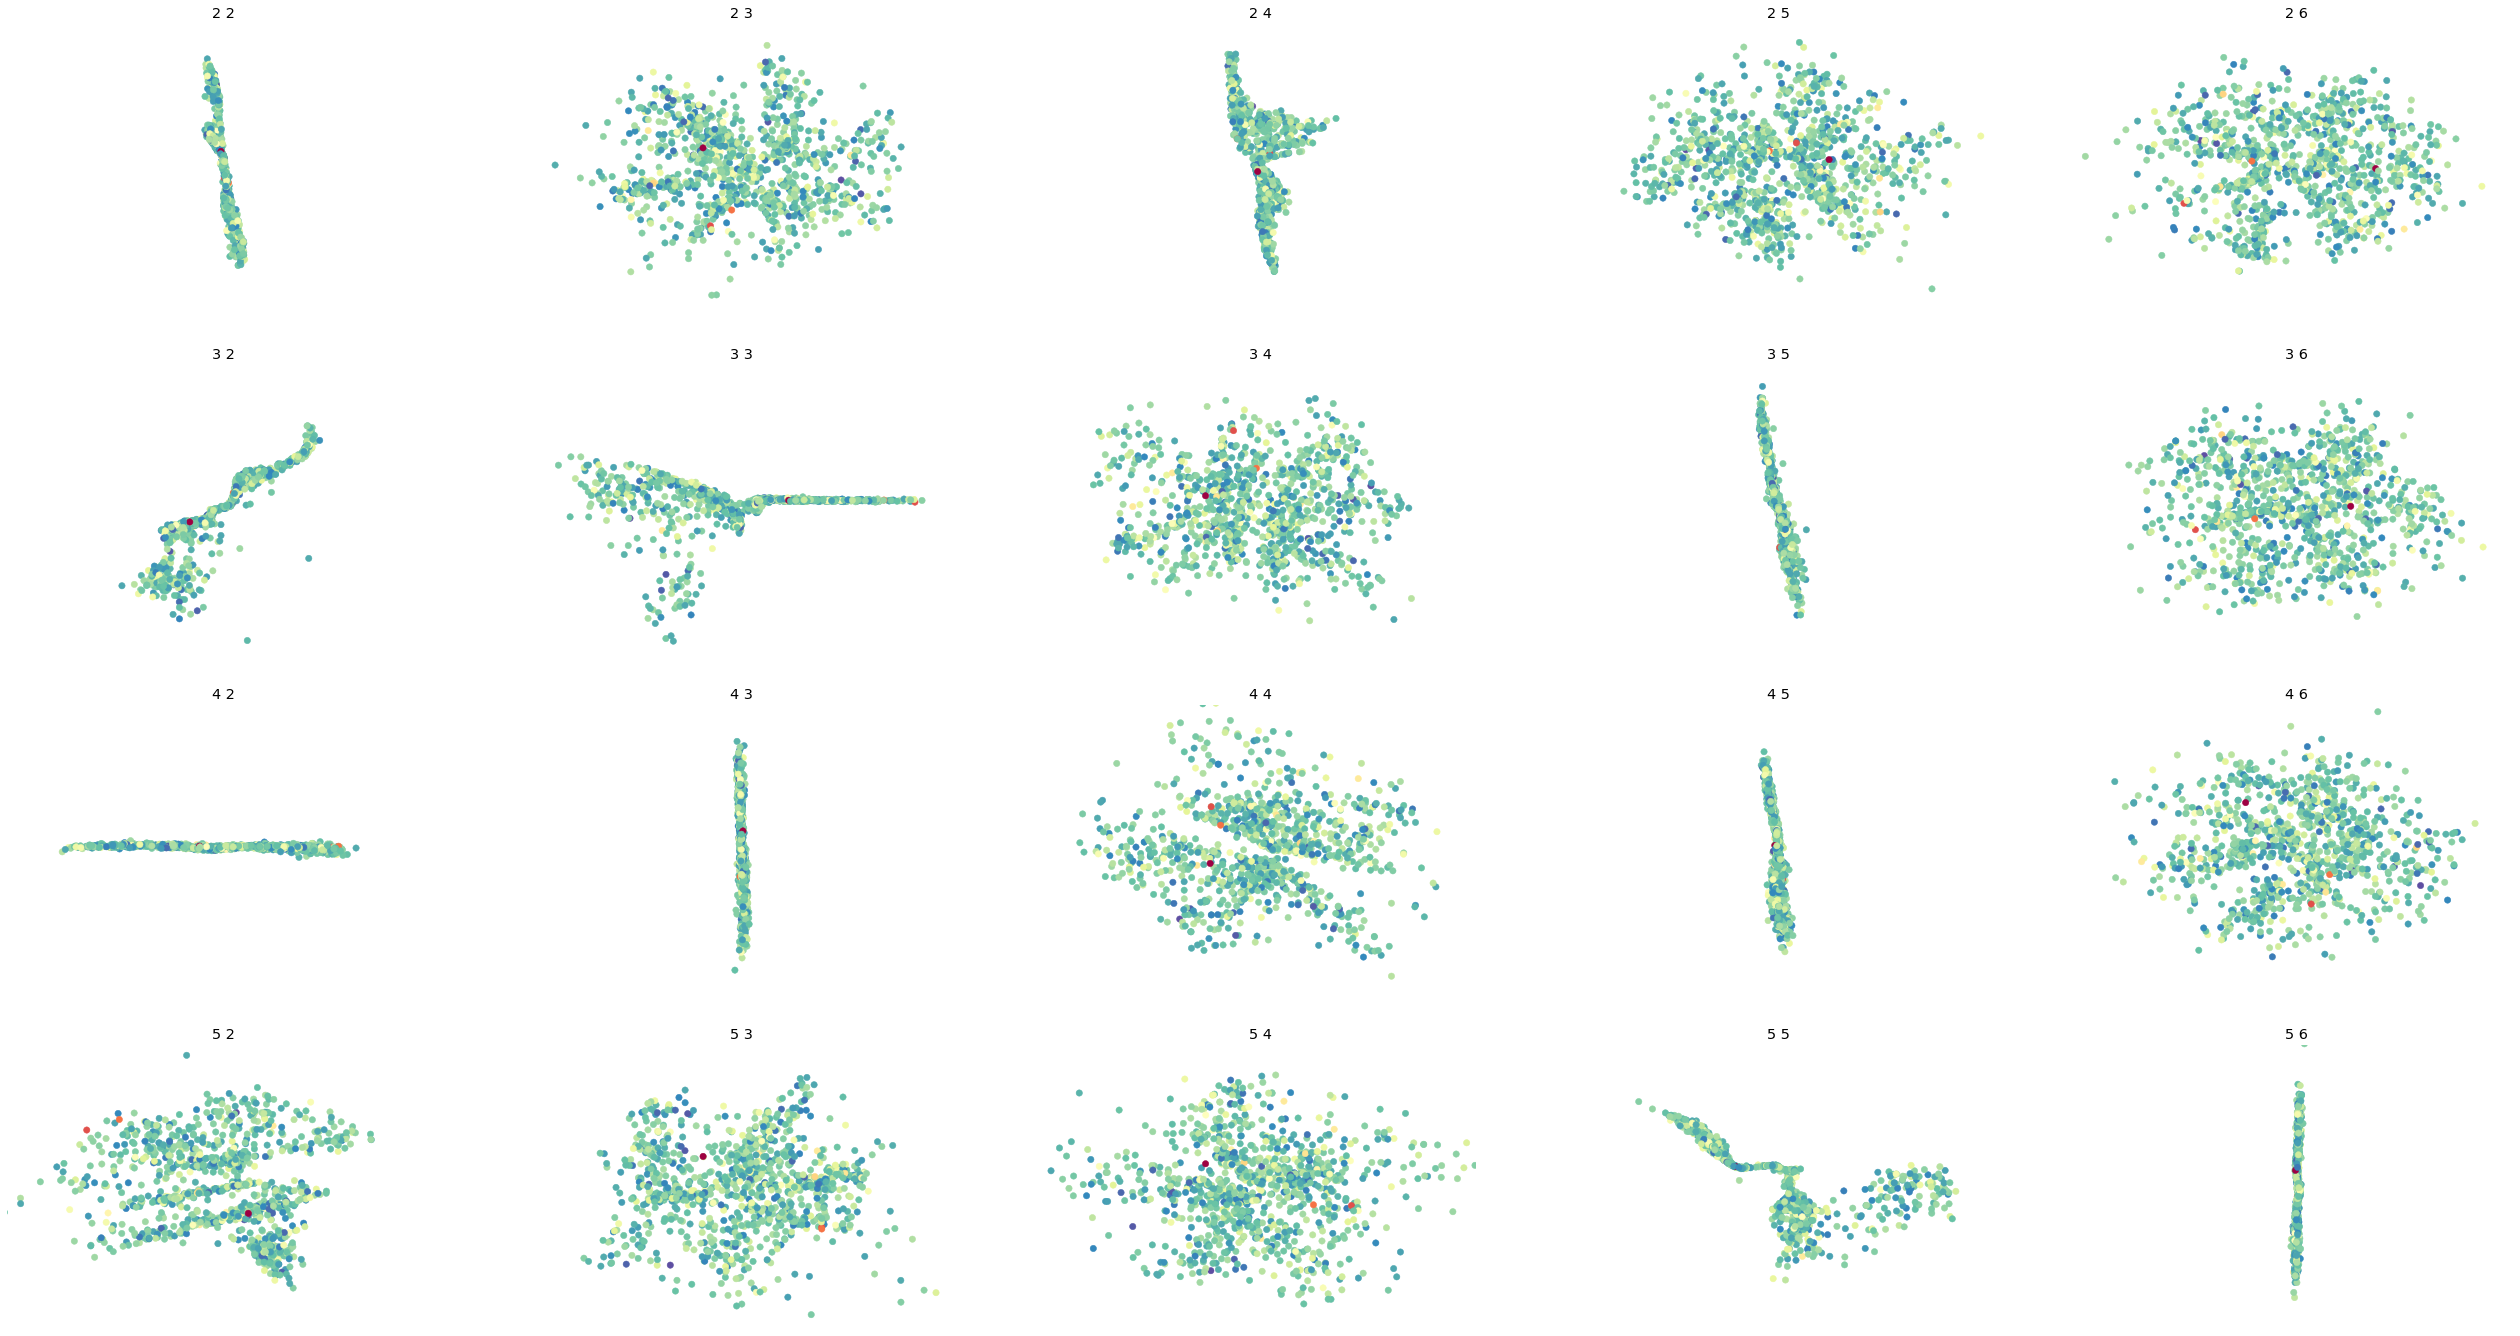

In [16]:
R = 3
fig = plt.figure()
i = 1
for logp_target in tqdm(range(2, 6)):
        for tpsa_target in tqdm(range(2, 7)):
            ax = plt.subplot(4, 5, i)
            ax.set_title('%d %d'%(logp_target, tpsa_target))
            ax.scatter(
                W_tsne[(logp_target, tpsa_target)][:, 0],
                W_tsne[(logp_target, tpsa_target)][:, 1],
                c = color,
                cmap=cmap,
                norm=norm,
                s=S
            )
            plt.xlim(-R, R)
            plt.ylim(-R, R)
            plt.axis('off')
            i += 1
fig.set_size_inches(8*5, 6*4)